# Задание 1

(**NB.** для запуска примеров кода нужен Python версии не ниже **3.10**, допускается использование других версий, в этом случае нужно самостоятельно избавиться от конструкции `match`).

Есть следующий код для [автоматического дифференцирования](https://en.wikipedia.org/wiki/Automatic_differentiation), в котором используются особенности системы типов языка `Python`: 

In [1]:
from dataclasses import dataclass
from typing import Union, Callable
from numbers import Number

@dataclass
class Dual:
    value: float
    d: float

    def __add__(self, other: Union["Dual", Number]) -> "Dual":
         match other:
            case Dual(o_value, o_d):
                return Dual(self.value + o_value, self.d + o_d)
            case Number():
                return Dual(float(other) + self.value, self.d)
             

    def __mul__(self, other: Union["Dual", Number]) -> "Dual":
         match other:
            case Dual(o_value, o_d):
                return Dual(self.value * o_value, self.value * o_d + self.d * o_value)
            case Number():
                return Dual(float(other) * self.value, float(other) * self.d)  
             
    def __sub__(self, other: Union["Dual", Number])-> "Dual":
        match other:
            case Dual(o_value, o_d):
                return Dual(self.value - o_value, self.d - o_d)
            case Number():
                return Dual(self.value - float(other), self.d)
            
    def __rsub__(self, other: Number) -> "Dual":
        return self.__neg__().__add__(other)
             
    def __pow__(self, power: Number) -> "Dual":
        return Dual(self.value**power, power * (self.value ** (power-1))) 

    __rmul__ = __mul__  # https://docs.python.org/3/reference/datamodel.html#object.__mul__
    __radd__ = __add__  # https://docs.python.org/3/reference/datamodel.html#object.__radd__


    def __truediv__(self, other: Union["Dual", Number]) -> "Dual":
        match other:
            case Dual(o_value, o_d):
                return Dual(self.value / o_value, (self.d * o_value - self.value * o_d) / (o_value*o_value))
                pass
            case Number():
                return Dual(self.value/float(other), self.d/float(other))  
            
    def __rtruediv__(self, other: Union["Dual", Number]) -> "Dual":
        match other:
            case Dual(o_value, o_d):
                return Dual(o_value / self.value, (self.value * o_d - self.d * o_value) / (self.value*self.value))
            case Number():
                return Dual(float(other)/self.value, -float(other)/(self.value**2))  
            
    def __ge__(self, other:float):
        return self.value >= other

    # унарные еоперации

    def __neg__(self):
        return Dual(-self.value, -self.d)

    def __pos__(self):
        return Dual(+self.value, +self.d)

    def __abs__(self):
        return Dual(self.value, self.d*(self.value >= 0) - self.d*(self.value < 0))
 

def diff(func: Callable[[float], float]) -> Callable[[float], float]:
    return lambda x: func(Dual(x, 1.0)).d 

Поддерживаются две операции - сложение и умножение. Применить можно так:

In [2]:
# Функция, которую будем дифференцировать
def f(x: float) -> float:
    return -x/(2*x*x + x)

f_diff = diff(f)

# значение производной в точке x = 2
f_diff(2)

0.08

## Задание 1.1 (5 баллов)

Какие недостатки вы видите в данной реализации? Реализуйте поддержку (полностью самостоятельно или модифицируя приведенный код):
- [унарных операций](https://docs.python.org/3/reference/datamodel.html#object.__neg__) 
- деления
- возведения в степень

Каким образом можно проверить корректность решения?  Реализуйте достаточный, по вашему мнению, набор тестов.

In [3]:
# ваш код
# функции добавил в исходный класс выше. тесты ниже.

def pow_test():
    assert diff(lambda x: x**2)(2) == (lambda x: 2*x)(2)
    assert diff(lambda x: x**7)(5) == (lambda x: 7*x**6)(5)
    assert diff(lambda x: x**(1/2))(10) == (lambda x: (1/2.0)*x**(-1/2.0))(10)
    return 'passed'

def del_test():
    assert diff(lambda x: 1/x)(2) == (lambda x: -1/(x**2))(2)
    assert diff(lambda x: x/(2*x*x + x))(3) == (lambda x: -2/((2*x + 1)**2))(3)
    return 'passed'

def neg_tests():
    assert diff(lambda x: -x)(0) == -1.0
    assert diff(lambda x: 7*-x)(2) == -7.0
    return 'passed'

def abs_tests():
    assert diff(lambda x: abs(x))(10) == 1.0
    assert diff(lambda x: abs(x))(-10) == -1.0
    return 'passed'

def neg_tests():
    assert diff(lambda x: -x)(10) == -1.0
    assert diff(lambda x: -x)(-10) == -1.0
    return 'passed'

def pos_tests():
    assert diff(lambda x: +x)(10) == 1.0
    assert diff(lambda x: +x)(-10) == 1.0
    return 'passed'

pow_test(), del_test(), neg_tests(), abs_tests(), neg_tests(), pos_tests()

('passed', 'passed', 'passed', 'passed', 'passed', 'passed')

## Задание 1.2 (7 баллов)
Придумайте способ и реализуйте поддержку функций:
- `exp()`
- `cos()`
- `sin()`
- `log()`

Добавьте соответствующие тесты

In [4]:
import math

def log(number: Union["Dual", Number]) -> "Dual":
    match number:
        case Dual():
            return Dual(math.log(number.value), number.d / (number.value))
        case Number():
            return math.log(float(number))
            

def exp(number: Union["Dual", Number]) -> "Dual":
    match number:
        case Dual():
            return Dual(math.exp(number.value), math.exp(number.value)*number.d)
        case Number():
            return math.exp(float(number))

def sin(number: Union["Dual", Number]) -> "Dual":
    match number:
        case Dual():
            return Dual(math.sin(number.value), number.d * math.cos(number.value))
        case Number():
            return math.sin(float(number))

def cos(number: Union["Dual", Number]) -> "Dual":
    match number:
        case Dual():
            return Dual(math.cos(number.value), -number.d * math.sin(number.value))
        case Number():
            return math.sin(float(number))

In [5]:
def log_tests():
    assert diff(lambda x: log(x))(2) == 1/2
    assert round(diff(lambda x: log(x/(x**2 + x)))(1), 4) == round((lambda x: -1/(x + 1))(1), 4)
    return 'passed'

def exp_tests():
    assert round(diff(lambda x: exp(x))(2),4) == round(math.e**2,4)
    return 'passed'

def sin_tests():
    assert diff(lambda x: sin(x))(0) == math.cos(0)
    assert diff(lambda x: sin(x*x + x))(1) == (lambda x: math.cos(x*x + x)*(2*x + 1))(1)
    return 'passed'

def cos_tests():
    assert diff(lambda x: cos(x))(0) == math.sin(0)
    assert diff(lambda x: cos(x*x + x))(1) == (lambda x: -math.sin(x*x + x)*(2*x + 1))(1)
    return 'passed'

log_tests(),exp_tests(), sin_tests(), cos_tests()
 

('passed', 'passed', 'passed', 'passed')

## Задание 1.3 (3 балла)

Воспользуйтесь методами **численного** дифференцирования для "проверки" работы кода на нескольких примерах. Например,  библиотеке `scipy` есть функция `derivative`. Или реализуйте какой-нибудь метод численного дифференцирования самостоятельно (**+5 баллов**)

In [6]:
from scipy.misc import derivative

def f(x: float) -> float:
    return 5 * x * x + 2 * x + 2

derivative(f, 2.)

/var/folders/qn/wj4_7b6s15b8h1mjnbzrfwyryqk4j8/T/ipykernel_28584/2371880734.py:6: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  derivative(f, 2.)


22.0

In [7]:
def f(x: float) -> float:
    return x*x + x +  1

assert derivative(f, 0)==diff(f)(0)
print('passed')

passed


/var/folders/qn/wj4_7b6s15b8h1mjnbzrfwyryqk4j8/T/ipykernel_28584/3847118011.py:4: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  assert derivative(f, 0)==diff(f)(0)


In [8]:
def f1(x: float) -> float:
    return x/10

assert round(derivative(f1, 10, dx=1.0/2**16), 4)==round(diff(f1)(10), 4)
print('passed')

passed


/var/folders/qn/wj4_7b6s15b8h1mjnbzrfwyryqk4j8/T/ipykernel_28584/2306332541.py:4: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  assert round(derivative(f1, 10, dx=1.0/2**16), 4)==round(diff(f1)(10), 4)


In [9]:
def f1(x: float) -> float:
    return sin(x/10)

assert round(derivative(f1, 10, dx=1.0/2**16), 4)==round(diff(f1)(10), 4)
print('passed')

passed


/var/folders/qn/wj4_7b6s15b8h1mjnbzrfwyryqk4j8/T/ipykernel_28584/1504929858.py:4: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  assert round(derivative(f1, 10, dx=1.0/2**16), 4)==round(diff(f1)(10), 4)


In [10]:
def f1(x: float) -> float:
    return log(x**2 + x +  1)

assert round(derivative(f1, 10, dx=1.0/2**16), 4)==round(diff(f1)(10), 4)
print('passed')

passed


/var/folders/qn/wj4_7b6s15b8h1mjnbzrfwyryqk4j8/T/ipykernel_28584/4040355142.py:4: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  assert round(derivative(f1, 10, dx=1.0/2**16), 4)==round(diff(f1)(10), 4)


## Задание 1.4 (10 баллов)

Необходимо разработать систему автоматического тестирования алгоритма дифференцирования в следующем виде:
- реализовать механизм генерации "случайных функций" (например, что-то вроде такого: $f(x) = x + 5 * x - \cos(20 * \log(12 - 20 * x * x )) - 20 * x$ )
- сгенерировать достаточно большое число функций и сравнить результаты символьного и численного дифференцирования в случайных точках 

Генерацию случайных функций можно осуществить, например, двумя путями. 
1. Генерировать функцию в текстовом виде, зачем использовать встроенную функцию [eval](https://docs.python.org/3/library/functions.html#eval)

```python
func = eval("lambda x: 2 * x + 5")
assert func(42) == 89 
```

2. Использовать стандартный модуль [ast](https://docs.python.org/3/library/ast.html), который позволяет во время выполнения программы манипулировать [Абстрактным Синтаксическим Деревом](https://ru.wikipedia.org/wiki/%D0%90%D0%B1%D1%81%D1%82%D1%80%D0%B0%D0%BA%D1%82%D0%BD%D0%BE%D0%B5_%D1%81%D0%B8%D0%BD%D1%82%D0%B0%D0%BA%D1%81%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%BE%D0%B5_%D0%B4%D0%B5%D1%80%D0%B5%D0%B2%D0%BE).
Например, выражение 

```python
func = lambda x: 2 * x + 5
```

Можно запрограммировать с помощью кода:

```python

expr = ast.Expression(
    body=ast.Lambda(
        args=ast.arguments(
            args=[
                ast.arg(arg='x')
            ],
            posonlyargs=[],
            kwonlyargs=[],
            kw_defaults=[],
            defaults=[]
        ),
        body=ast.BinOp(
            left=ast.BinOp(
                left=ast.Constant(value=2),
                op=ast.Mult(),
                right=ast.Name(id='x', ctx=ast.Load())
            ),
            op=ast.Add(),
            right=ast.Constant(value=5)
        )
    )
)

ast.fix_missing_locations(expr)

func = eval(compile(expr, filename="", mode="eval"))

assert func(42) == 89
```

При реализации нужно учитывать области допустимых значений функций.

In [11]:
import random
import sympy as sp

def generate_symbolic_function():
    x = sp.symbols('x')
    function_type = random.choice(['polynomial', 'exponential', 'logarithmic', 'sin', 'cos', 'composition'])
    # function_type = 'exponential'
    if function_type == 'polynomial':
        degree = random.randint(1, 3)
        coefficients = [sp.Rational(random.randint(-5, 5)) for _ in range(degree + 1)]
        polynomial_function = sum(coefficients[i] * x**i for i in range(degree + 1))
        return polynomial_function
    elif function_type == 'exponential':
        a = sp.Rational(random.randint(1, 5))
        b = sp.Rational(random.randint(1, 5))
        exponential_function = a * sp.exp(b * x)
        return exponential_function
    elif function_type == 'logarithmic':
        a = sp.Rational(random.randint(1, 5))
        b = sp.Rational(random.randint(1, 5))
        logarithmic_function = a * sp.log(b * x + 1)
        return logarithmic_function
    elif function_type == 'sin':
        return sp.sin(x)
    elif function_type == 'cos':
        return sp.cos(x)
    else:  # composition of functions
        inner_function = generate_symbolic_function()
        outer_function = generate_symbolic_function()
        return outer_function.subs(x, inner_function)


# Пример использования

In [69]:
TEST_COUNT = 50

passed_count = 0

error_cases = []

for i in range(TEST_COUNT):
    dot = round(random.random(),4)
    
    symb_func = generate_symbolic_function
    str_func = 'lambda x:' + str(symb_func())
    func = eval(str_func)

    auto_res = round(diff(func)(dot), 4)
    numeric_res = round(derivative(func, dot, dx=1e-8), 4)
    
    if auto_res == numeric_res:
        passed_count += 1
    else:
        error_cases.append({
            'dot':dot,
            'function': str_func,
            'auto_res':auto_res,
            'numeric_res':numeric_res}
        )
print('passed:', f'{passed_count}/{TEST_COUNT}')

passed: 38/50


/var/folders/qn/wj4_7b6s15b8h1mjnbzrfwyryqk4j8/T/ipykernel_28584/1870142475.py:15: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  numeric_res = round(derivative(func, dot, dx=1e-8), 4)


## Тесты прошли не все.
Но почему? Давайте разбираться.

In [77]:
for j, i in enumerate(error_cases):
    print('точка:',i['dot'])
    print('функция:', str(i['function']))

    print('результат класса авто-дифференцирования:', i['auto_res'])
    print('численный результат:', i['numeric_res'])
    print('============')
    if j == 5:
        break


точка: 0.6984
функция: lambda x:cos(x)
результат класса авто-дифференцирования: -0.643
численный результат: 0.7659
точка: 0.2144
функция: lambda x:cos(x)
результат класса авто-дифференцирования: -0.2128
численный результат: 0.9771
точка: 0.7108
функция: lambda x:cos(x)
результат класса авто-дифференцирования: -0.6524
численный результат: 0.7578
точка: 0.3664
функция: lambda x:cos(cos(x))
результат класса авто-дифференцирования: 0.288
численный результат: 0.8743
точка: 0.6003
функция: lambda x:-2*sin(x)**2 - 4*sin(x) + 3
результат класса авто-дифференцирования: -5.5602
численный результат: -5.1652
точка: 0.7092
функция: lambda x:8*exp(15*x) - 20*exp(10*x) - 8*exp(5*x) - 1
результат класса авто-дифференцирования: 4760868.1227
численный результат: 4760868.1489


## На самом деле авто-диференцирование не ошиблось.
Проблема в том, что численное дифференцирование считает с погрешностью. Если подставить в wolframalpha значение, видно, что результаты авто-дифференцирования правильные.

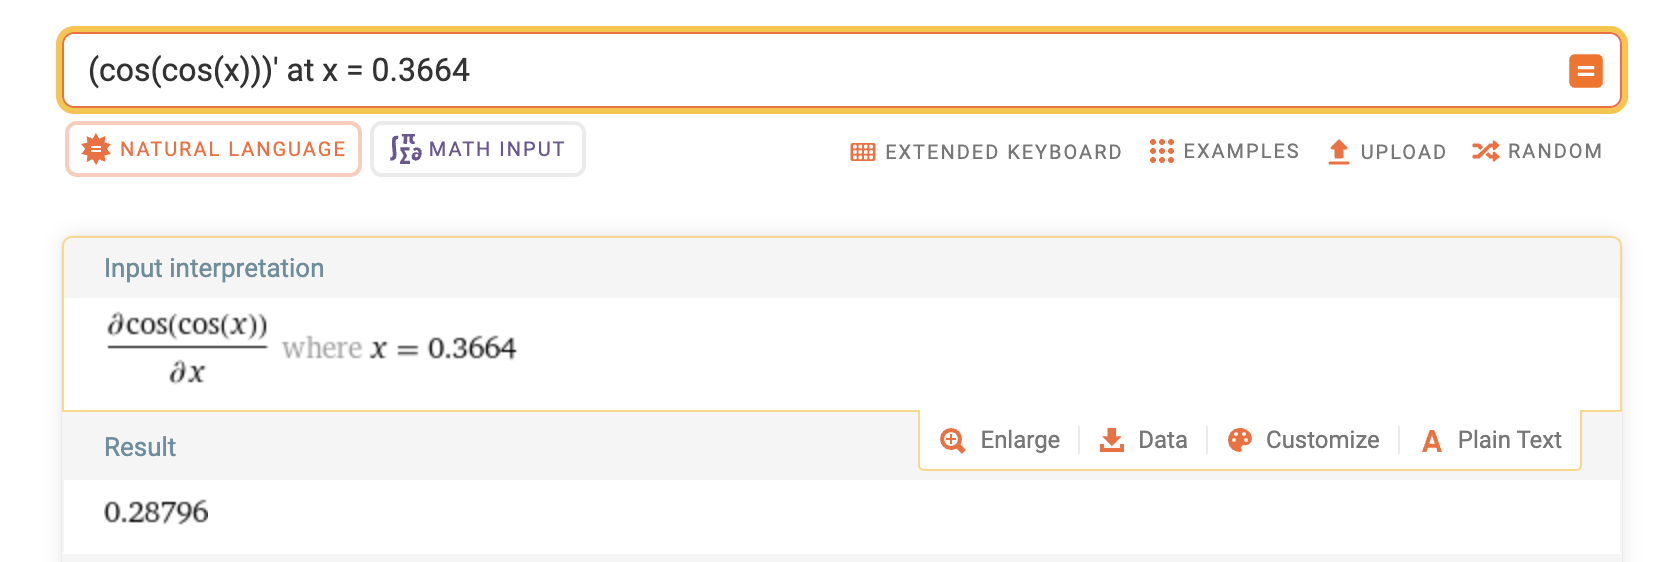

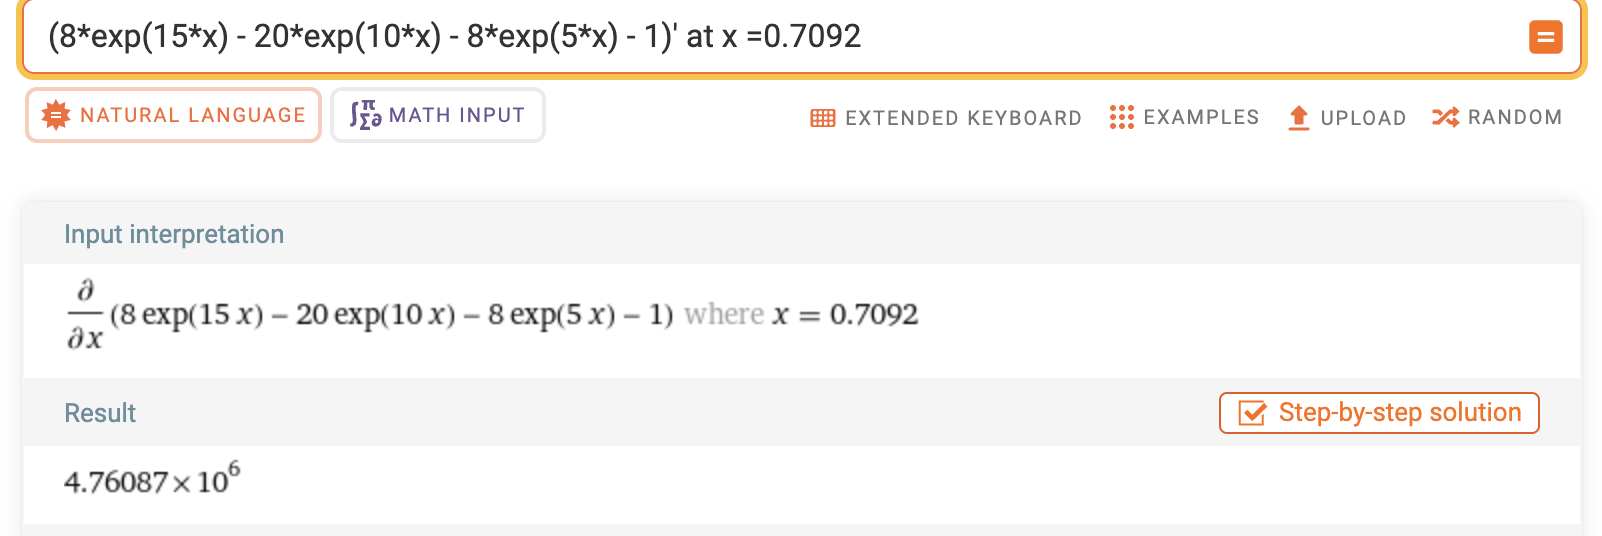

## Задание 1.5 (7 баллов)

Реализуйте поддержку функций нескольких аргументов. Например

```python
def f(x: float, y: float, z: float) -> float:
    return x * y + z - 5 * y  


f_diff = diff(f)

f_diff(10, 10, 10) # = [10, 5, 1]
```

In [91]:
from typing import Callable, List, Union
from dataclasses import dataclass

@dataclass
class Multi:
    value: float
    d: List[float]

    def __add__(self, other: Union["Multi", float]) -> "Multi":
        if isinstance(other, Multi):
            return Multi(self.value + other.value, [self.d[i] + other.d[i] for i in range(len(self.d))])
        else:
            return Multi(self.value + other, self.d)

    def __mul__(self, other: Union["Multi", float]) -> "Multi":
        if isinstance(other, Multi):
            new_value = self.value * other.value
            new_gradient = [self.d[i] * other.value + self.value * other.d[i] for i in range(len(self.d))]
            return Multi(new_value, new_gradient)
        else:
            return Multi(self.value * other, [self.d[i] * other for i in range(len(self.d))])

    def __neg__(self) -> "Multi":
        return Multi(-self.value, [-x for x in self.d])

    def __pos__(self) -> "Multi":
        return Multi(+self.value, [+x for x in self.d])

    __radd__ = __add__
    __rmul__ = __mul__

def custom_function(a: float, b: float, c: float) -> float:
    return a * b + c + (-5) * b

def custom_gradient(func: Callable[[float, float, float], List[float]]) -> Callable[[float, float, float], List[float]]:
    return lambda x, y, z: func(Multi(x, (1, 0, 0)), Multi(y, (0, 1, 0)), Multi(z, (0, 0, 1))).d

custom_function_gradient = custom_gradient(custom_function)
print(custom_function_gradient(10, 10, 10)) 

[10, 5, 1]
